# DATA20001 Deep Learning - Group Project
## Text project

**Due Thursday, May 20, before 23:59.**

The task is to learn to assign the correct labels to news articles.  The corpus contains ~850K articles from Reuters.  The test set is about 10% of the articles. The data is unextracted in XML files.

We're only giving you the code for downloading the data, and how to save the final model. The rest you'll have to do yourselves.

Some comments and hints particular to the project:

- One document may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are documents that don't belong to any class, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.
- You may use word-embeddings to get better results. For example, you were already using a smaller version of the GloVE  embeddings in exercise 4. Do note that these embeddings take a lot of memory. 
- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

## Get the data

In [1]:
import sys
import os
from os.path import join
from os.path import abspath
from os.path import split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets.utils import download_url

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection  import train_test_split
import zipfile

root_dir = os.getcwd()
if root_dir not in sys.path:
    sys.path.append(root_dir)
    
train_path = 'train'

data_folder_name = 'text-training-corpus'
DATA_FOLDER_DIR = os.path.abspath(os.path.join(root_dir, data_folder_name))

data_zip_name = 'reuters-training-corpus.zip'
DATA_ZIP_DIR = os.path.abspath(os.path.join(DATA_FOLDER_DIR, data_zip_name))

#with zipfile.ZipFile(DATA_ZIP_DIR) as zip_f:
#    zip_f.extractall(train_path)

In [2]:
#pip install pytorch-nlp
#pip install lxml

The above command downloads and extracts the data files into the `train` subdirectory.

The files can be found in `train/`, and are named as `19970405.zip`, etc. You will have to manage the content of these zips to get the data. There is a readme which has links to further descriptions on the data.

The class labels, or topics, can be found in the readme file called `train/codes.zip`.  The zip contains a file called "topic_codes.txt".  This file contains the special codes for the topics (about 130 of them), and the explanation - what each code means.  

The XML document files contain the article's headline, the main body text, and the list of topic labels assigned to each article.  You will have to extract the topics of each article from the XML.  For example: 
&lt;code code="C18"&gt; refers to the topic "OWNERSHIP CHANGES" (like a corporate buyout).

You should pre-process the XML to extract the words from the article: the &lt;headline&gt; element and the &lt;text&gt;.  You should not need any other parts of the article.

## Your stuff goes here ...

In [3]:
from bs4 import BeautifulSoup as bs
import re
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from torchnlp.encoders.text import StaticTokenizerEncoder,stack_and_pad_tensors, pad_tensor
import pickle

In [4]:
train_path = os.path.abspath(os.path.join(root_dir, train_path))
reuters_unzipped_path = os.path.abspath(os.path.join(train_path, 'REUTERS_CORPUS_2'))

zipped_news_files = os.listdir(os.path.abspath(reuters_unzipped_path))
del zipped_news_files[-3:] # remove files: codes.zip, dtds.zip, readme.txt
#zipped_news_files

Generating dataframe. Takes ~5min.

In [5]:
text_project_path = 'text-project'
topic_codes = 'topic_codes.txt'

DATA_FOLDER_DIR = os.path.abspath(os.path.join(root_dir, text_project_path))

topic_codes_location = os.path.abspath(os.path.join(DATA_FOLDER_DIR, topic_codes))

# from get_data.py
def get_codes(codefile):
    codes = {}
    i = 0
    with open(codefile, 'r') as cf:
        for line in cf:
            if not line.startswith(';'):
                code = line.strip().split('\t')[0]
                codes[code] = i
                i += 1
    return codes

CODEMAP = get_codes(topic_codes_location)
CODEMAP_list = (list(CODEMAP.keys()))

In [6]:
%%time

rows_list = []
pattern = r'"([A-Za-z0-9_\./\\-]*)"'

for news_file in zipped_news_files:
    zf = zipfile.ZipFile(os.path.abspath(os.path.join(reuters_unzipped_path, news_file)), 'r')
    for name in zf.namelist():
        dict1 = {} # saving into dicts which are then saved into a list which is then saved into the df.
        f = zf.open(name).read()
        soup = bs(f, "lxml")
        
        #title = soup.title.text
        dict1["title"] = soup.title.text
        dict1["text"] = soup.find("text").text
        codes = []
        metadata_codes = soup.metadata.find_all("code")
        
        for val in metadata_codes:
            m = re.search(pattern, str(val))
            codes.append(m.group().replace('"', ''))
        
        dict1["codes"] = [value for value in codes if value in CODEMAP_list] # remove unnecessary codes
        
        rows_list.append(dict1)
    break # remove break for full dataframe
df = pd.DataFrame(rows_list, columns=['title', 'text', 'codes'])

CPU times: user 14.7 s, sys: 50.2 ms, total: 14.7 s
Wall time: 14.8 s


In [7]:
#Check out the dataframe
df.head()

,title,text,codes
0,"USA: Philip Morris head says open to ""reasonab...",\nPhilip Morris Cos. Inc. Chief Executive Geof...,"[C12, CCAT, GCAT, GCRIM]"
1,USA: Reynolds says smokers spurned low tar cig...,\nThe chief of development at R.J. Reynolds To...,"[C12, CCAT, GCAT, GCRIM]"
2,USA: Bill introduced to cut U.S. tobacco subsi...,\nA bipartisan bill to cut federal subsidies f...,"[C13, C17, CCAT]"
3,EU: OFFICIAL JOURNAL CONTENTS - OJ L 105 OF A...,\n*\nDecision No 710/97/EC of the European Par...,"[G15, GCAT]"
4,EU: OFFICIAL JOURNAL CONTENTS - OJ C 127 OF A...,\n*\n(Note - contents are displayed in reverse...,"[G15, GCAT]"


In [8]:
#inspect the text content
df.loc[1]["text"]

'\nThe chief of development at R.J. Reynolds Tobacco Co. told a court hearing a wrongful death suit Thursday that smokers had spurned cigarettes with a lower tar and nicotine content.\nDavid Townsend, the first defence witness and director of product development and assessment for Reynolds, said the company had made "extraordinary efforts" to reduce tar, nicotine and other elements deemed harmful to health by medical experts.\nIt had introduced filters, extracted elements and tried different ways of ventilating cigarettes.\nConsumers rejected the cigarettes as they did not taste good, he said.\nOver 1992 and 1993, Reynolds developed a cigarette called Premier in what he called the most intense project it had ever undertaken. When it was test-marketed , it was a resounding failure, Townsend said.\nThe company was currently test-marketing in Tennessee another product called Eclipse which he called the "most advanced cigarette design" he had seen.\nIn the case, plaintiff Dana Raulerson is

In [9]:
def display_Codes(df):
    codes = df["codes"].values  #Get the Codes from the dataframe
    
    #Convert the list of lists to a single list
    code_list= []
    for sublist in codes:
        for item in sublist:
            code_list.append(item)
            
    #Get unique codes from the list        
    code_list_unique = np.array(code_list)
    print("Unique number of codes: ", len(np.unique(code_list_unique)))
    
    
    #Count the frequency of codes in the list
    code_freq = nltk.FreqDist(code_list)
    
    code_freq_df = pd.DataFrame({'Code': list(code_freq.keys()), 
                              'Count': list(code_freq.values())})
    
    #Convert the count to a dataframe and plot codes with more than 50 counts
    g = code_freq_df.nlargest(columns="Count", n=50)
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=g, x= "Count", y = "Code") 
    ax.set(ylabel = 'Count') 
    plt.show()

Unique number of codes:  95


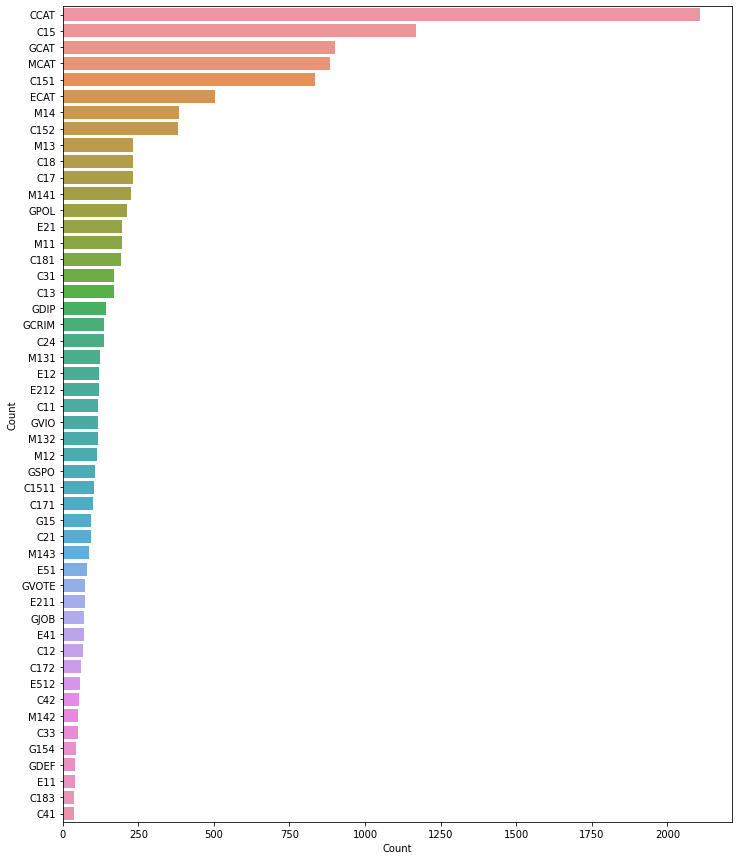

In [10]:
display_Codes(df)

In [11]:
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\n'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

In [12]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)



In [13]:
lemmatizer = WordNetLemmatizer() 

def lemmatize(words):
    lemmatized_text = [lemmatizer.lemmatize(t, pos='n') for t in words] # lemmatized nouns
    return ''.join(lemmatized_text)

In [14]:
def implement_clean_text(df):
    df['clean_text'] = df['text'].apply(lambda x: clean_text(x))
    df['clean_text'] = df['clean_text'].apply(lambda x: remove_stopwords(x))
    df['clean_text'] = df['clean_text'].apply(lambda x: lemmatize(x))
    return df

In [15]:
df = implement_clean_text(df)

In [16]:
#inspect column
df.loc[1]["clean_text"]


'chief development r j reynolds tobacco co told court hearing wrongful death suit thursday smokers spurned cigarettes lower tar nicotine content david townsend first defence witness director product development assessment reynolds said company made extraordinary efforts reduce tar nicotine elements deemed harmful health medical experts introduced filters extracted elements tried different ways ventilating cigarettes consumers rejected cigarettes taste good said reynolds developed cigarette called premier called intense project ever undertaken test marketed resounding failure townsend said company currently test marketing tennessee another product called eclipse called advanced cigarette design seen case plaintiff dana raulerson suing reynolds behalf estate children jean connor sister died lung cancer age earlier thursday circuit judge bernard nachman dismissed one juror panel leaving alternates juror sandra grant told reuters rushed courthouse mother law dying said asked nachman could 

In [17]:
def create_encoder(data, input_column="clean_text", output_column="codes", X_encoder_filename = 'X_encoder.pickle', Y_encoder_filename='Y_encoder.pickle'):
    
    encoder = StaticTokenizerEncoder(data[input_column])
    
    multilabel_binarizer = MultiLabelBinarizer()
    multilabel_binarizer.fit(data[output_column])
    
    with open(X_encoder_filename, 'wb') as handle:
        pickle.dump(encoder, handle)
    with open(Y_encoder_filename, 'wb') as handle:
        pickle.dump(multilabel_binarizer, handle)
    
    return encoder, multilabel_binarizer

In [18]:
def tokenize_data(data,X_encoder, Y_encoder,input_column="clean_text", output_column="codes"):
    x_raw = [X_encoder.encode(x) for x in df[input_column]]
    max_len = max([len(x) for x in x_raw])
    x_raw = [np.array([pad_tensor(x, length=max_len).numpy()]) for x in x_raw]
    
    y_raw = Y_encoder.transform(data[output_column])
    
    return x_raw, y_raw

In [19]:
def load_encoder(X_encoder_filename = 'X_encoder.pickle', Y_encoder_filename='Y_encoder.pickle'):
    with open (X_encoder_filename, 'rb') as handle:
        X_encoder = pickle.load(handle)
    
    with open(Y_encoder_filename, 'rb') as handle:
        Y_encoder = pickle.load(handle)
    
    return X_encoder, Y_encoder

In [20]:
use_preexisting_x_encoder = False
use_preexisting_y_encoder = False

In [21]:
if (use_preexisting_x_encoder and use_preexisting_y_encoder):
    x_encoder, y_encoder = load_encoder()
else:
    x_encoder, y_encoder = create_encoder(data=df)

In [50]:
x_input, y_input = tokenize_data(df, x_encoder, y_encoder)

In [51]:
X_train,X_valid, y_train, y_valid = train_test_split(x_input, y_input, test_size=0.2) 

In [52]:
class createDataset(Dataset):
    def __init__(self, X,Y):
        self.X = X
        self.y=Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return  torch.from_numpy(self.X[idx][0]).long(), torch.from_numpy(self.y[idx]).long()

In [53]:
train_ds = createDataset(X_train,y_train)
valid_ds = createDataset(X_valid, y_valid)

In [54]:
train_loader = DataLoader(train_ds, batch_size = 100)
valid_loader = DataLoader(valid_ds, batch_size=100)

In [55]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([100, 3812]) type: torch.LongTensor
y_train: torch.Size([100, 95]) type: torch.LongTensor


In [56]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using CPU


In [57]:
class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim,output_size):
        super().__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim,padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim,hidden_dim,batch_first=True)
        self.linear = nn.Linear(hidden_dim,output_size)
    
    def forward(self,x):
        x= self.embeddings(x)
        lstm_output, (ht,states) = self.lstm(x)
        output = torch.sigmoid(self.linear(ht[-1]))
        return output

In [78]:
encoder = x_encoder

model = LSTM_Model(encoder.vocab_size,20,20,y_input[0].shape[0])
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.5)
criterion = nn.MultiLabelSoftMarginLoss() # not cross-entropy, we should talk about this in the report

In [79]:
print(model)

LSTM_Model(
  (embeddings): Embedding(29198, 20, padding_idx=0)
  (lstm): LSTM(20, 20, batch_first=True)
  (linear): Linear(in_features=20, out_features=95, bias=True)
)


In [85]:
def train(epoch,log_interval=5):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        #print(batch_idx)
        data= data.to(device)
        target = target.to(device)
        target= target.float()
        data = data.long()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        #print(loss.data.item())
        loss.backward()
        
        optimizer.step()     
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [96]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    accuracy_metric = []
    val_loss, correct = 0, 0
    for data, target in valid_loader:
        data = data.to(device)
        target = target.to(device)
        #print(target[0])
        target= target.float()
        data = data.long()
        output = model(data)
        #print(output.data[0])
        val_loss += criterion(output, target).data.item()
        
        acc = torch.abs(output - target).view(-1)
        #print(acc)
        acc = (1. - acc.sum() / acc.size()[0]) * 100.
        #print(acc)
        accuracy_metric.append(acc)
        #break
        #pred = output.data.max(1)[1] # get the index of the max log-probability
        #correct += pred.eq(target.data).cpu().sum()

    #val_loss /= len(valid_loader)
    #loss_vector.append(val_loss)
    
            
        
        
    accuracy = np.sum(accuracy_metric) / len(valid_loader.dataset)
    
    accuracy_vector.append(accuracy)
    
    print('\nAccuracy: {}/{} ({:.0f}%)\n'.format(accuracy))

In [97]:
%%time
epochs = 1

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    #train(epoch)
    validate(lossv, accv)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0.5020, 0.4368, 0.4605, 0.5546, 0.4882, 0.5257, 0.4411, 0.4595, 0.5129,
        0.5151, 0.4685, 0.5028, 0.5333, 0.5186, 0.5271, 0.5534, 0.4846, 0.4720,
        0.4594, 0.5452, 0.5017, 0.5241, 0.5039, 0.4859, 0.5222, 0.5017, 0.4725,
        0.5266, 0.4867, 0.4640, 0.4873, 0.4546, 0.5408, 0.4682, 0.4678, 0.5589,
        0.5126, 0.5251, 0.5358, 0.5197, 0.4774, 0.4980, 0.5362, 0.5200, 0.4385,
        0.5126, 0.4655, 0.5250, 0.4637, 0.4584, 0.4832, 0.5234, 0.4532, 0.4709,
        0.4911, 0.4543, 0.4827, 0.5071, 0.4753, 0.4831, 0.4752, 0.5101, 0.4467,
        0.5007, 0.4462, 0.4557, 0.4964, 0.5445, 0.5204, 0.5304, 0.5093, 0.4948,
        0.4912, 0.5686, 0.5401, 0.4655, 0.

RuntimeError: The size of tensor a (100) must match the size of tensor b (95) at non-singleton dimension 1

## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [35]:
torch.save(model.state_dict(), 'model.pkl')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

## Predict for test set

You will be asked to return your predictions a separate test set.  These should be returned as a matrix with one row for each test article.  Each row contains a binary prediction for each label, 1 if it's present in the image, and 0 if not. The order of the labels is the order of the label (topic) codes.

An example row could like like this if your system predicts the presense of the second and fourth topic:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0 ...
    
If you have the matrix prepared in `y` you can use the following function to save it to a text file.

In [36]:
np.savetxt('results.txt', y, fmt='%d')

NameError: name 'y' is not defined